# Plotting odometry histograms

This notebook builds on the "Plotting odometry data" notebook that you were working with earlier. In addition to plotting timeseries we will explore the data by plotting histograms, which accumulates data over time to visualize how samples are distributed. We will work with the same data set as before.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import pupil_recording_interface as pri

## Load data

In [2]:
folder = Path("data")
subject = "AJR"

Below, we use pupil_recording_interface to load the data

In [3]:
accel = pri.load_dataset(folder / subject, accel="recording", cache=False)
gyro = pri.load_dataset(folder / subject, gyro="recording", cache=False)
odometry = pri.load_dataset(folder / subject, odometry="recording", cache=False)

As before, we will first look at the raw data from the Realsense gyroscope. First we will plot the full time series.


In [4]:
gyro

<xarray.Dataset>
Dimensions:           (cartesian_axis: 3, time: 3489638)
Coordinates:
  * time              (time) datetime64[ns] 2021-05-10T17:02:51.938754816 ......
  * cartesian_axis    (cartesian_axis) <U1 'x' 'y' 'z'
Data variables:
    angular_velocity  (time, cartesian_axis) float64 0.006392 ... -0.01172

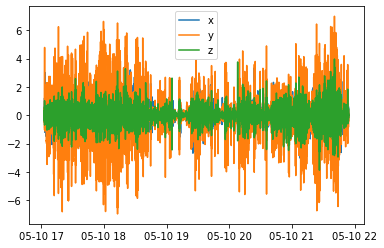

In [10]:
plt.plot(gyro.time,gyro.angular_velocity)
plt.legend(['x','y','z'])

Now we accumulate the data over time to see how it is distributed for each axis/dimension (x,y,z). We use the matplotlib hist function and specify 100 bins within the range of -2.5 to +2.5 rad/s.

(array([2.00000e+01, 2.50000e+01, 4.20000e+01, 4.20000e+01, 4.60000e+01,
        5.70000e+01, 5.70000e+01, 7.30000e+01, 9.60000e+01, 8.90000e+01,
        1.18000e+02, 1.08000e+02, 1.26000e+02, 1.46000e+02, 1.58000e+02,
        2.02000e+02, 2.71000e+02, 2.49000e+02, 2.79000e+02, 3.12000e+02,
        3.81000e+02, 4.61000e+02, 5.66000e+02, 5.79000e+02, 7.07000e+02,
        8.48000e+02, 1.02100e+03, 1.23600e+03, 1.53800e+03, 1.76700e+03,
        2.08300e+03, 2.54800e+03, 3.00200e+03, 3.36700e+03, 4.22300e+03,
        5.34600e+03, 6.82700e+03, 8.79500e+03, 1.10230e+04, 1.42390e+04,
        1.83480e+04, 2.38210e+04, 3.09520e+04, 4.02600e+04, 5.27660e+04,
        6.97680e+04, 9.19380e+04, 1.26455e+05, 1.96154e+05, 8.45285e+05,
        8.89615e+05, 1.95633e+05, 1.22724e+05, 8.84200e+04, 6.55090e+04,
        5.08170e+04, 3.90770e+04, 2.99430e+04, 2.28750e+04, 1.77690e+04,
        1.45080e+04, 1.12160e+04, 8.93700e+03, 7.17000e+03, 5.68000e+03,
        4.69800e+03, 3.80200e+03, 3.04500e+03, 2.65

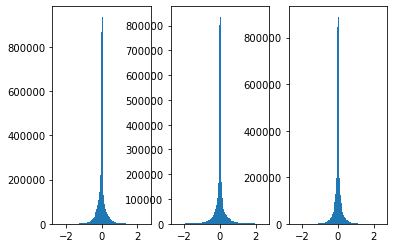

In [15]:
plt.subplot(131)
plt.hist(gyro.angular_velocity.sel(cartesian_axis='x'),100,[-2.5,2.5])
plt.subplot(132)
plt.hist(odometry.angular_velocity.sel(cartesian_axis='y'),100,[-2.5,2.5])
plt.subplot(133)
plt.hist(odometry.angular_velocity.sel(cartesian_axis='z'),100,[-2.5,2.5])

What we learn from this is that angular velocity along a given axis is very often close to zero and is rarely larger than 1 rad/sec.

OK, let's try the same thing with the accelerometer data.

In [6]:
accel

<xarray.Dataset>
Dimensions:              (cartesian_axis: 3, time: 1089412)
Coordinates:
  * time                 (time) datetime64[ns] 2021-05-10T17:02:51.934886656 ...
  * cartesian_axis       (cartesian_axis) <U1 'x' 'y' 'z'
Data variables:
    linear_acceleration  (time, cartesian_axis) float64 0.2295 10.04 ... 3.308

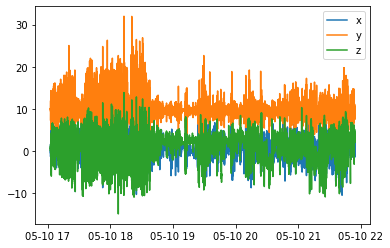

In [16]:
plt.plot(accel.time,accel.linear_acceleration)
plt.legend(['x','y','z'])

We make histograms with 100 bins again, but we select a different range for each of the axes.

(array([4.7000e+01, 5.1000e+01, 7.4000e+01, 7.3000e+01, 8.9000e+01,
        1.0700e+02, 1.3500e+02, 1.4600e+02, 2.1100e+02, 3.5200e+02,
        4.9800e+02, 5.6100e+02, 6.3600e+02, 5.7200e+02, 6.2500e+02,
        7.7400e+02, 8.1400e+02, 1.0060e+03, 1.1450e+03, 1.4240e+03,
        1.4410e+03, 2.3870e+03, 2.4830e+03, 2.8630e+03, 2.6640e+03,
        2.8480e+03, 4.1520e+03, 4.0920e+03, 7.4550e+03, 4.8540e+03,
        7.4680e+03, 8.4070e+03, 8.2130e+03, 7.6730e+03, 1.1290e+04,
        1.4187e+04, 1.0882e+04, 1.1345e+04, 1.3283e+04, 1.5059e+04,
        1.4995e+04, 1.6892e+04, 1.6057e+04, 1.7521e+04, 1.8297e+04,
        2.0723e+04, 1.6635e+04, 2.1321e+04, 1.7985e+04, 1.9277e+04,
        2.3357e+04, 2.0665e+04, 2.3229e+04, 2.3969e+04, 2.6079e+04,
        2.6699e+04, 3.6805e+04, 3.4821e+04, 4.8422e+04, 6.1386e+04,
        6.3464e+04, 6.2155e+04, 5.3683e+04, 4.6757e+04, 4.1815e+04,
        4.1993e+04, 2.6646e+04, 2.1916e+04, 1.7274e+04, 1.2366e+04,
        9.3450e+03, 7.6860e+03, 5.2560e+03, 4.73

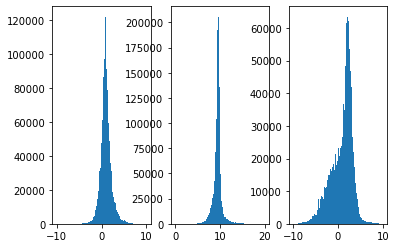

In [21]:
plt.subplot(131)
plt.hist(accel.linear_acceleration.sel(cartesian_axis='x'),100,[-10,10])
plt.subplot(132)
plt.hist(accel.linear_acceleration.sel(cartesian_axis='y'),100,[0,20])
plt.subplot(133)
plt.hist(accel.linear_acceleration.sel(cartesian_axis='z'),100,[-10,10])

We learn that gravity is acting most often along y-axis, which shows a peak in the histogram near 9.8 m/s^2. We can also observe that these histograms are asymmetrical. Given that the total acceleration is often dominated by gravitational acceleration, what might be causing this assymetry?

OK, now lets work with some odometry data.

In [22]:
odometry

<xarray.Dataset>
Dimensions:               (cartesian_axis: 3, quaternion_axis: 4, time: 3391498)
Coordinates:
  * time                  (time) datetime64[ns] 2021-05-10T17:02:52.268046080...
  * cartesian_axis        (cartesian_axis) <U1 'x' 'y' 'z'
  * quaternion_axis       (quaternion_axis) <U1 'w' 'x' 'y' 'z'
Data variables:
    position              (time, cartesian_axis) float64 0.0 0.0 ... -66.23
    linear_velocity       (time, cartesian_axis) float64 0.0 0.0 ... 0.01896
    angular_velocity      (time, cartesian_axis) float64 0.02149 ... -0.003685
    linear_acceleration   (time, cartesian_axis) float64 0.0 0.0 ... 0.1805
    angular_acceleration  (time, cartesian_axis) float64 1.825 1.825 ... -0.9135
    confidence            (time) int64 2 2 2 2 2 2 2 2 2 2 ... 3 3 3 3 3 3 3 3 3
    orientation           (time, quaternion_axis) float64 0.9995 ... -0.1801

We have a separate estimate of angular velocity available here. Let's plot it and see whether it differs much from the gyro data.

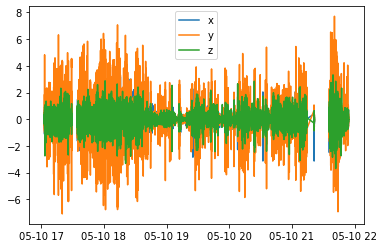

In [23]:
plt.plot(odometry.time,odometry.angular_velocity)
plt.legend(['x','y','z'])

(array([2.00000e+01, 2.50000e+01, 4.20000e+01, 4.20000e+01, 4.60000e+01,
        5.70000e+01, 5.70000e+01, 7.30000e+01, 9.60000e+01, 8.90000e+01,
        1.18000e+02, 1.08000e+02, 1.26000e+02, 1.46000e+02, 1.58000e+02,
        2.02000e+02, 2.71000e+02, 2.49000e+02, 2.79000e+02, 3.12000e+02,
        3.81000e+02, 4.61000e+02, 5.66000e+02, 5.79000e+02, 7.07000e+02,
        8.48000e+02, 1.02100e+03, 1.23600e+03, 1.53800e+03, 1.76700e+03,
        2.08300e+03, 2.54800e+03, 3.00200e+03, 3.36700e+03, 4.22300e+03,
        5.34600e+03, 6.82700e+03, 8.79500e+03, 1.10230e+04, 1.42390e+04,
        1.83480e+04, 2.38210e+04, 3.09520e+04, 4.02600e+04, 5.27660e+04,
        6.97680e+04, 9.19380e+04, 1.26455e+05, 1.96154e+05, 8.45285e+05,
        8.89615e+05, 1.95633e+05, 1.22724e+05, 8.84200e+04, 6.55090e+04,
        5.08170e+04, 3.90770e+04, 2.99430e+04, 2.28750e+04, 1.77690e+04,
        1.45080e+04, 1.12160e+04, 8.93700e+03, 7.17000e+03, 5.68000e+03,
        4.69800e+03, 3.80200e+03, 3.04500e+03, 2.65

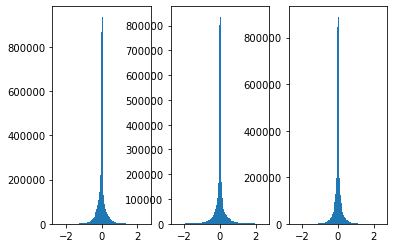

In [24]:
plt.subplot(131)
plt.hist(gyro.angular_velocity.sel(cartesian_axis='x'),100,[-2.5,2.5])
plt.subplot(132)
plt.hist(odometry.angular_velocity.sel(cartesian_axis='y'),100,[-2.5,2.5])
plt.subplot(133)
plt.hist(odometry.angular_velocity.sel(cartesian_axis='z'),100,[-2.5,2.5])

There is a gap toward the end of the timeseries plot. This suggests that the odometry suffered some kind of failure during this time segment, but gyro data was still collected. The histograms looks very similar.

OK, now lets check out the linear velocity estimate, which we only get from the odometry.

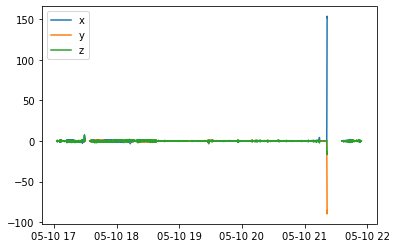

In [25]:
plt.plot(odometry.time,odometry.linear_velocity)
plt.legend(['x','y','z'])

(array([6.00000e+01, 4.90000e+01, 5.30000e+01, 6.60000e+01, 8.90000e+01,
        1.53000e+02, 2.00000e+02, 2.98000e+02, 4.02000e+02, 5.54000e+02,
        9.87000e+02, 1.19300e+03, 1.46500e+03, 1.81700e+03, 2.47900e+03,
        2.66700e+03, 2.91300e+03, 3.48800e+03, 4.91900e+03, 5.72900e+03,
        6.85000e+03, 8.23200e+03, 9.42200e+03, 9.70100e+03, 1.04510e+04,
        1.12630e+04, 1.22960e+04, 1.26000e+04, 1.33630e+04, 1.31950e+04,
        1.39740e+04, 1.53270e+04, 1.74210e+04, 1.83370e+04, 1.96880e+04,
        2.10700e+04, 2.19160e+04, 2.16950e+04, 2.19870e+04, 2.11670e+04,
        2.06710e+04, 2.08110e+04, 2.25300e+04, 2.49870e+04, 2.75660e+04,
        3.32080e+04, 4.50050e+04, 8.04040e+04, 1.53749e+05, 9.43971e+05,
        9.18683e+05, 1.13700e+05, 5.44020e+04, 3.73990e+04, 2.75380e+04,
        2.13530e+04, 2.04580e+04, 1.94770e+04, 1.76400e+04, 1.58270e+04,
        1.51930e+04, 1.62690e+04, 1.69170e+04, 1.71760e+04, 1.63540e+04,
        1.50560e+04, 1.39660e+04, 1.27370e+04, 1.06

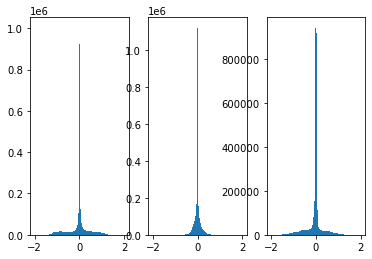

In [27]:
plt.subplot(131)
plt.hist(odometry.linear_velocity.sel(cartesian_axis='x'),100,[-2,2])
plt.subplot(132)
plt.hist(odometry.linear_velocity.sel(cartesian_axis='y'),100,[-2,2])
plt.subplot(133)
plt.hist(odometry.linear_velocity.sel(cartesian_axis='z'),100,[-2,2])

The timeseries plot is hard to inspect due to the large transients that occur near the end of the recording. Can you figure out how to recale the y-axis to better inspect this data?

The histograms show that data for x and z axes are similarly distributed, whereas y-axis data (velocity in the vertical direction) shows much less variance. But recall that this raw odometry data is different from the processed data. Let's look at that now.

In [28]:
accel_calib = xr.open_dataset(folder / subject / "acceleration.nc")

In [29]:
accel_calib

<xarray.Dataset>
Dimensions:            (cartesian_axis: 3, time: 957908)
Coordinates:
  * time               (time) datetime64[ns] 2021-05-10T17:03:51.006111860 .....
  * cartesian_axis     (cartesian_axis) object 'x' 'y' 'z'
Data variables:
    linear_acc         (time, cartesian_axis) float64 ...
    inertial_acc       (time, cartesian_axis) float64 ...
    gravitational_acc  (time, cartesian_axis) float64 ...
    inertial_2_acc     (time, cartesian_axis) float64 ...
    linear_vel         (time, cartesian_axis) float64 ...
    angular_vel        (time, cartesian_axis) float64 ...
    confidence         (time) float64 ...

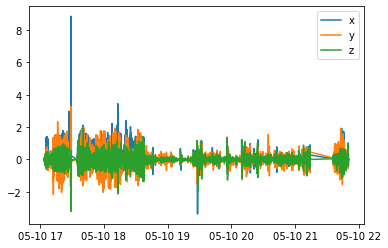

In [31]:
plt.plot(accel_calib.time,accel_calib.linear_vel)
plt.legend(['x','y','z'])

(array([1.20000e+01, 1.40000e+01, 9.00000e+00, 8.00000e+00, 8.00000e+00,
        1.90000e+01, 1.30000e+01, 7.00000e+00, 2.00000e+00, 1.30000e+01,
        2.10000e+01, 2.50000e+01, 2.30000e+01, 1.90000e+01, 1.80000e+01,
        1.90000e+01, 2.00000e+01, 1.50000e+01, 3.50000e+01, 3.80000e+01,
        3.50000e+01, 3.90000e+01, 5.00000e+01, 4.90000e+01, 8.00000e+01,
        8.70000e+01, 8.80000e+01, 1.32000e+02, 1.35000e+02, 1.82000e+02,
        2.92000e+02, 4.62000e+02, 6.16000e+02, 8.33000e+02, 1.02100e+03,
        1.40100e+03, 1.85200e+03, 2.35300e+03, 3.04200e+03, 4.02900e+03,
        4.99800e+03, 5.92400e+03, 7.04700e+03, 8.58100e+03, 1.04730e+04,
        1.35190e+04, 1.79050e+04, 2.47550e+04, 4.35520e+04, 3.31825e+05,
        3.02900e+05, 4.93750e+04, 2.80400e+04, 1.96870e+04, 1.48520e+04,
        1.15500e+04, 9.60500e+03, 7.90100e+03, 6.57900e+03, 5.35500e+03,
        4.08800e+03, 3.15700e+03, 2.35300e+03, 1.78100e+03, 1.30600e+03,
        8.73000e+02, 7.06000e+02, 4.88000e+02, 2.78

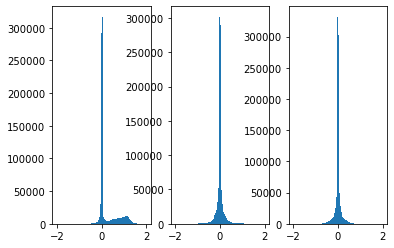

In [32]:
plt.subplot(131)
plt.hist(accel_calib.linear_vel.sel(cartesian_axis='x'),100,[-2,2])
plt.subplot(132)
plt.hist(accel_calib.linear_vel.sel(cartesian_axis='y'),100,[-2,2])
plt.subplot(133)
plt.hist(accel_calib.linear_vel.sel(cartesian_axis='z'),100,[-2,2])

Notice that these histograms have a very different shape. The histogram for the x-axis linear velocity is bimodal, with a second peak near 1 m/s. And  the y and z-axis histograms show a similar distribution. What can account for these changes relative to the unprocessed linear velocity data?

Now, we will generate a 2D histogram of the y and z axis linear velocity data. 

(array([[ 4.,  1.,  2., ...,  3.,  9.,  5.],
        [ 3.,  3.,  4., ...,  5.,  2.,  3.],
        [ 2.,  3.,  5., ...,  3.,  7.,  3.],
        ...,
        [ 4.,  5.,  4., ...,  5.,  3.,  7.],
        [ 5.,  8.,  3., ...,  3.,  8.,  5.],
        [11.,  1.,  1., ...,  6.,  8.,  5.]]),
 array([-0.1  , -0.098, -0.096, -0.094, -0.092, -0.09 , -0.088, -0.086,
        -0.084, -0.082, -0.08 , -0.078, -0.076, -0.074, -0.072, -0.07 ,
        -0.068, -0.066, -0.064, -0.062, -0.06 , -0.058, -0.056, -0.054,
        -0.052, -0.05 , -0.048, -0.046, -0.044, -0.042, -0.04 , -0.038,
        -0.036, -0.034, -0.032, -0.03 , -0.028, -0.026, -0.024, -0.022,
        -0.02 , -0.018, -0.016, -0.014, -0.012, -0.01 , -0.008, -0.006,
        -0.004, -0.002,  0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,
         0.012,  0.014,  0.016,  0.018,  0.02 ,  0.022,  0.024,  0.026,
         0.028,  0.03 ,  0.032,  0.034,  0.036,  0.038,  0.04 ,  0.042,
         0.044,  0.046,  0.048,  0.05 ,  0.052,  0.054,  0.056,  0.

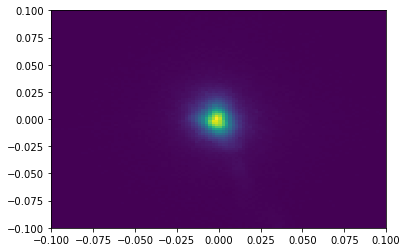

In [47]:
plt.hist2d(accel_calib.linear_vel.sel(cartesian_axis='z'),accel_calib.linear_vel.sel(cartesian_axis='y'),100,[[-.1,.1],[-.1,.1]])

This histogram shows the components of linear velocity acting along the head-horiztonal (inter-aural) and head-vertical axes. This is a proxy for the direction of linear velocity in the frontal plane, also known as the heading direction. It is centered around straight ahead, because humans face forward in the direction they are walking, but with some variability due to head bob and shake during walking. 

We can learn something similar by examining the gravitational acceleration field of the processed accelerometer data. This data indicates how the components of the gravity vector (9.8 m/s^2) are distributed along the head-centered x, y, and z axes. From this data, we can learn how the head is tilted relative to gravity.

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.70000e+01, 9.00000e+00,
        1.30000e+01, 6.00000e+00, 5.00000e+00, 5.00000e+00, 3.00000e+00,
        4.00000e+00, 5.00000e+00, 4.00000e+00, 6.00000e+00, 2.60000e+01,
        6.00000e+01, 1.58000e+02, 7.20000e+01, 8.20

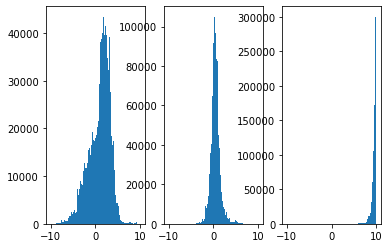

In [43]:
plt.subplot(131)
plt.hist(accel_calib.gravitational_acc.sel(cartesian_axis='x'),100,[-10,10])
plt.subplot(132)
plt.hist(accel_calib.gravitational_acc.sel(cartesian_axis='y'),100,[-10,10])
plt.subplot(133)
plt.hist(accel_calib.gravitational_acc.sel(cartesian_axis='z'),100,[-10,10])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-7.65898623e+00, -7.51159450e+00, -7.36420277e+00, -7.21681105e+00,
        -7.06941932e+00, -6.92202759e+00, -6.77463587e+00, -6.62724414e+00,
        -6.47985242e+00, -6.33246069e+00, -6.18506896e+00, -6.03767724e+00,
        -5.89028551e+00, -5.74289378e+00, -5.59550206e+00, -5.44811033e+00,
        -5.30071860e+00, -5.15332688e+00, -5.00593515e+00, -4.85854342e+00,
        -4.71115170e+00, -4.56375997e+00, -4.41636825e+00, -4.26897652e+00,
        -4.12158479e+00, -3.97419307e+00, -3.82680134e+00, -3.67940961e+00,
        -3.53201789e+00, -3.38462616e+00, -3.23723443e+00, -3.08984271e+00,
        -2.94245098e+00, -2.79505925e+00, -2.64766753e+00, -2.50027580e+00,
        -2.35288408e+00, -2.20549235e+00, -2.05810062e+00, -1.91070

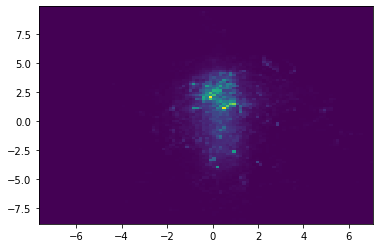

In [48]:
plt.hist2d(accel_calib.gravitational_acc.sel(cartesian_axis='y'),accel_calib.gravitational_acc.sel(cartesian_axis='x'),100)

The vertical and horiztonal axes show how the head is pitched and rolled realtive to gravity. The vertical distrbituions is skewed toward the downward direction, that is downward head tilt.